New logic: Swire would want to predict the abandonment couple of days before the end of the window. 
Fit training data with cart abandonment but only up to the last 2 windows of puchase or abandon. 
Then for the test data, test/predict only couples days in not wait untill the end of the window. 

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_validate
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder


from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer


# from lightgbm import LGBMClassifier
# import xgboost as xgb
# from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns


# Clean google analytics.csv and join with customer.csv 


In [2]:
ga = pd.read_csv("Copy of google_analytics.csv")
pd.set_option('display.max_columns', None)
ga.head()

,CUSTOMER_ID,EVENT_DATE,EVENT_TIMESTAMP,EVENT_NAME,DEVICE_CATEGORY,DEVICE_MOBILE_BRAND_NAME,DEVICE_OPERATING_SYSTEM,EVENT_PAGE_NAME,EVENT_PAGE_TITLE,ITEMS
0,501508595,2025-04-07,2025-04-07T14:57:40.713Z,view_search_results,mobile,Samsung,Android,Product List,NaN,[]
1,501730915,2025-04-07,2025-04-07T19:28:54.546Z,view_item_list,desktop,Google,Windows,NaN,Search,"[{""item_id"":""158520"",""quantity"":""1""},{""item_id..."
2,501567329,2025-04-07,2025-04-07T21:40:56.281Z,purchase,desktop,Google,Windows,MyCoke Orders - Purchase Success,Order,"[{""item_id"":""138335"",""quantity"":""2""},{""item_id..."
3,501765083,2025-04-08,2025-04-08T06:06:36.717Z,user_engagement,mobile,Apple,iOS,NaN,NaN,[]
4,501707837,2025-04-08,2025-04-08T18:12:10.511Z,view_item_list,desktop,Google,Windows,MyCoke Orders,Category: All Products,"[{""item_id"":""412588"",""quantity"":""1""},{""item_id..."


In [3]:
# Getting only cart affected events
ga_cart_events = ga[ga['EVENT_NAME'].isin(['add_to_cart', 'remove_from_cart','purchase'])]

In [4]:
# Join customer.csv with ga_cart_events to get customer's local time 
customer = pd.read_csv('Copy of customer.csv')

customer_ga_cart_events = pd.merge(ga_cart_events, customer, left_on='CUSTOMER_ID', right_on='CUSTOMER_NUMBER', how='left')

In [5]:
from zoneinfo import ZoneInfo
import pandas as pd

# ---- 1) City → timezone map (as you had) ----
city_tz = {
    "Tacoma, WA":"America/Los_Angeles","Spokane, WA":"America/Los_Angeles",
    "Arlington, WA":"America/Los_Angeles","Bellevue, WA":"America/Los_Angeles",
    "Walla Walla, WA":"America/Los_Angeles","Reno, NV":"America/Los_Angeles",
    "Elko, NV":"America/Los_Angeles","Pendleton, OR":"America/Los_Angeles",
    "Eugene, OR":"America/Los_Angeles","Wilsonville, OR":"America/Los_Angeles",
    "Bend, OR":"America/Los_Angeles","LaGrande, OR":"America/Los_Angeles",
    "Lewiston, ID":"America/Los_Angeles","Wenatchee, WA":"America/Los_Angeles",
    "Bremerton, WA":"America/Los_Angeles",
    "Denver, CO":"America/Denver","Colorado Springs, CO":"America/Denver",
    "Grand Junction, CO":"America/Denver","Glenwood Springs, CO":"America/Denver",
    "Pueblo, CO":"America/Denver","Alamosa, CO":"America/Denver",
    "Johnstown, CO":"America/Denver","Cheyenne, WY":"America/Denver",
    "Richfield, UT":"America/Denver","Draper, UT":"America/Denver",
    "Logan, UT":"America/Denver","Ogden, UT":"America/Denver",
    "Price, UT":"America/Denver","Albuquerque, NM":"America/Denver",
    "Scottsbluff, NE":"America/Denver",
    "Boise, ID":"America/Boise","Idaho Falls, ID":"America/Boise","Pocatello, ID":"America/Boise",
    "Tempe, AZ":"America/Phoenix","Tucson, AZ":"America/Phoenix",
    "Prescott, AZ":"America/Phoenix","Glendale, AZ":"America/Phoenix",
    "Kingman, AZ":"America/Phoenix","Huachuca City, AZ":"America/Phoenix",
    "Show Low, AZ":"America/Phoenix","Flagstaff, AZ":"America/Phoenix",
    "Yuma, AZ":"America/Phoenix",
}

# ---- 2) Parse timestamp as UTC (kept your column name) ----
customer_ga_cart_events["EVENT_TIMESTAMP_UTC"] = pd.to_datetime(
    customer_ga_cart_events["EVENT_TIMESTAMP"], utc=True, errors="coerce"
)

# ---- 3) Map timezone from CITY (use CITY consistently) ----
customer_ga_cart_events["TIMEZONE"] = customer_ga_cart_events["SALES_OFFICE_DESCRIPTION"].map(city_tz)

# ---- 4) Convert to local datetime per-row (only when TIMEZONE present) ----
customer_ga_cart_events["EVENT_LOCAL_DT"] = customer_ga_cart_events.apply(
    lambda row: (
        row["EVENT_TIMESTAMP_UTC"].astimezone(ZoneInfo(row["TIMEZONE"]))
        if pd.notna(row["TIMEZONE"]) and pd.notna(row["EVENT_TIMESTAMP_UTC"])
        else pd.NaT
    ),
    axis=1
)

# ---- 5) Convenience columns: date / hour / day-of-week ----
customer_ga_cart_events["EVENT_LOCAL_DATE"] = customer_ga_cart_events["EVENT_LOCAL_DT"].apply(
    lambda v: v.date() if pd.notna(v) else pd.NaT
)
customer_ga_cart_events["EVENT_LOCAL_TIME"] = customer_ga_cart_events["EVENT_LOCAL_DT"].apply(
    lambda v: v.strftime("%I:%M:%S %p") if pd.notna(v) else pd.NA
)
customer_ga_cart_events["EVENT_LOCAL_DOW"] = customer_ga_cart_events["EVENT_LOCAL_DT"].apply(
    lambda v: v.day_name() if pd.notna(v) else pd.NA
)

# ---- 6) Drop duplicates (use the actual UTC column name) ----
customer_ga_cart_events = customer_ga_cart_events.drop_duplicates(
    subset=["CUSTOMER_ID","EVENT_TIMESTAMP_UTC","EVENT_NAME"],
    keep="first"
)

# ---- 7) Select relevant columns (use consistent names) ----
cols = [
    "CUSTOMER_ID","CITY","TIMEZONE","EVENT_NAME",
    "EVENT_LOCAL_TIME","EVENT_LOCAL_DT","EVENT_LOCAL_DATE",
    "EVENT_LOCAL_HOUR","EVENT_LOCAL_DOW",
    "DEVICE_CATEGORY","DEVICE_MOBILE_BRAND_NAME","DEVICE_OPERATING_SYSTEM",
    "EVENT_PAGE_NAME","EVENT_PAGE_TITLE"
]
existing_cols = [c for c in cols if c in customer_ga_cart_events.columns]
customer_ga_cart_events = customer_ga_cart_events[existing_cols]

customer_ga_cart_events.head()


,CUSTOMER_ID,TIMEZONE,EVENT_NAME,EVENT_LOCAL_TIME,EVENT_LOCAL_DT,EVENT_LOCAL_DATE,EVENT_LOCAL_DOW,DEVICE_CATEGORY,DEVICE_MOBILE_BRAND_NAME,DEVICE_OPERATING_SYSTEM,EVENT_PAGE_NAME,EVENT_PAGE_TITLE
0,501567329,America/Los_Angeles,purchase,02:40:56 PM,2025-04-07 14:40:56.281000-07:00,2025-04-07,Monday,desktop,Google,Windows,MyCoke Orders - Purchase Success,Order
1,501702910,America/Denver,add_to_cart,12:30:14 PM,2025-05-24 12:30:14.025000-06:00,2025-05-24,Saturday,desktop,Google,Windows,NaN,Search
2,501565777,America/Phoenix,add_to_cart,01:08:07 PM,2025-05-20 13:08:07.167000-07:00,2025-05-20,Tuesday,mobile,Samsung,Android,NaN,Search
3,501752380,America/Los_Angeles,add_to_cart,02:25:29 PM,2025-05-16 14:25:29.494000-07:00,2025-05-16,Friday,desktop,Apple,Macintosh,NaN,Search
4,500549947,America/Los_Angeles,add_to_cart,06:12:45 PM,2025-04-07 18:12:45.609000-07:00,2025-04-07,Monday,mobile,Apple,iOS,Product List,NaN


# The windows from master.csv

check between purchaes from order and purchase from GA, check how much missing is there. Finlay's table is already in windows format, can't use this because of new logic. 

In [6]:
windows = pd.read_csv('new_master.csv')

In [7]:
#Make name clear
windows['ORDER_CREATED_DATE_UTC'] = windows['CREATED_DATE_UTC']


#Drop leakage columns and column from GA adding later
windows = windows.drop(columns=['num_add_to_cart_events','total_items_added_to_cart',
                                'purchases','button_clicks','total_events','DISTRIBUTION_MODE',
                                'ABANDONED_CART','SALES_OFFICE_DESC','CREATED_DATE_EST','CREATED_DATE_UTC',
                                'ORDER_QUANTITY','ORDER_TYPE','MATERIAL_LIST'])



In [8]:
pd.set_option('display.max_columns', None)

windows.head(20)

,CUSTOMER_ID,ANCHOR_DATE,NEXT_ANCHOR_SAME_WD,SALES_OFFICE,SHIPPING_CONDITIONS_DESC,DISTRIBUTION_MODE_DESC,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,CUTOFFTIME__C,ORDER_EXISTS,SHIPPING_CONDITIONS,ORDER_CREATED_DATE_UTC
0,500245685,2025-02-17,2025-02-24,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaN
1,500245685,2025-03-17,2025-03-24,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaN
2,500245685,2025-04-14,2025-04-21,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaN
3,500245685,2025-04-28,2025-05-05,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaN
4,500245738,2024-11-20,2024-11-27,G111,48 Hours,OFS,Wednesday,7,5:00:00 PM,1,48,2024-11-22 18:46:16+00:00
5,500245738,2024-11-27,2024-12-04,G111,48 Hours,OFS,Wednesday,7,5:00:00 PM,1,48,2024-11-28 02:46:16+00:00
6,500245738,2024-12-04,2024-12-11,G111,48 Hours,OFS,Wednesday,7,5:00:00 PM,1,48,2024-12-04 22:02:03+00:00
7,500245738,2024-12-11,2024-12-18,G111,48 Hours,OFS,Wednesday,7,5:00:00 PM,1,48,2024-12-13 01:44:02+00:00
8,500245738,2024-12-18,2024-12-25,G111,48 Hours,OFS,Wednesday,7,5:00:00 PM,1,48,2024-12-23 22:36:08+00:00
9,500245738,2025-01-08,2025-01-15,G111,48 Hours,OFS,Wednesday,7,5:00:00 PM,1,48,2025-01-08 19:21:06+00:00


# windows join customer_ga_cart_events

Join exploded windows to Google Analytics, with cart events only.

Left merge from windows and filter for correct dates of GA within windows. 

In [9]:
# Ensure datetime types
windows["ANCHOR_DATE"] = pd.to_datetime(windows["ANCHOR_DATE"])
windows["NEXT_ANCHOR_SAME_WD"] = pd.to_datetime(windows["NEXT_ANCHOR_SAME_WD"])
customer_ga_cart_events["EVENT_LOCAL_DATE"] = pd.to_datetime(customer_ga_cart_events["EVENT_LOCAL_DATE"])

# Perform a LEFT merge (windows = left table)
windows_with_ga = pd.merge(
    windows,
    customer_ga_cart_events,
    on="CUSTOMER_ID",
    how="left"
)


windows_with_ga["WINDOW_START_LOCAL"] = pd.to_datetime(
    windows_with_ga["ANCHOR_DATE"].dt.strftime("%Y-%m-%d") + " " + windows_with_ga['CUTOFFTIME__C'],   #CUTOFFTIME__C	?
    errors="coerce"
)
windows_with_ga["WINDOW_END_LOCAL"] = pd.to_datetime(
    windows_with_ga["NEXT_ANCHOR_SAME_WD"].dt.strftime("%Y-%m-%d") + " " + windows_with_ga['CUTOFFTIME__C'],
    errors="coerce"
)

# 2) Drop timezone from the event’s local datetime so it’s naive too
windows_with_ga["EVENT_LOCAL_NAIVE"] = windows_with_ga["EVENT_LOCAL_DT"].apply(
    lambda v: pd.NaT if pd.isna(v) else pd.Timestamp(v).tz_localize(None)
)

# 1) Build in-window mask (compare naive-to-naive)
in_window = (
    (windows_with_ga["EVENT_LOCAL_NAIVE"] >= windows_with_ga["WINDOW_START_LOCAL"]) &
    (windows_with_ga["EVENT_LOCAL_NAIVE"] <  windows_with_ga["WINDOW_END_LOCAL"])
)

# Turn ORDER_CREATED_DATE_UTC to local time 
windows_with_ga['ORDER_CREATED_DATE_UTC'] = pd.to_datetime(
    windows_with_ga['ORDER_CREATED_DATE_UTC'], utc=True, errors="coerce"
    ) 

windows_with_ga['ORDER_CREATED_DATE_LOCAL'] = windows_with_ga.apply(
    lambda row: (
        row["ORDER_CREATED_DATE_UTC"].astimezone(ZoneInfo(row["TIMEZONE"]))
        if pd.notna(row["TIMEZONE"]) and pd.notna(row["ORDER_CREATED_DATE_UTC"])
        else pd.NaT
    ),
    axis=1
)

windows_with_ga = windows_with_ga[in_window].copy()





C:\Users\dhung\AppData\Local\Temp\ipykernel_18700\2625391076.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  windows_with_ga["WINDOW_START_LOCAL"] = pd.to_datetime(
C:\Users\dhung\AppData\Local\Temp\ipykernel_18700\2625391076.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  windows_with_ga["WINDOW_END_LOCAL"] = pd.to_datetime(


This is all the GA cart events for each windows. Each windows migh have many events (unaggreagated)

In [10]:
windows_with_ga[windows_with_ga['CUSTOMER_ID']==501730915].head()

,CUSTOMER_ID,ANCHOR_DATE,NEXT_ANCHOR_SAME_WD,SALES_OFFICE,SHIPPING_CONDITIONS_DESC,DISTRIBUTION_MODE_DESC,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,CUTOFFTIME__C,ORDER_EXISTS,SHIPPING_CONDITIONS,ORDER_CREATED_DATE_UTC,TIMEZONE,EVENT_NAME,EVENT_LOCAL_TIME,EVENT_LOCAL_DT,EVENT_LOCAL_DATE,EVENT_LOCAL_DOW,DEVICE_CATEGORY,DEVICE_MOBILE_BRAND_NAME,DEVICE_OPERATING_SYSTEM,EVENT_PAGE_NAME,EVENT_PAGE_TITLE,WINDOW_START_LOCAL,WINDOW_END_LOCAL,EVENT_LOCAL_NAIVE,ORDER_CREATED_DATE_LOCAL
1721073,501730915,2024-11-14,2024-11-21,G141,48 Hours,Sideload,Thursday,7,3:00:00 PM,1,48,2024-11-18 16:01:15+00:00,America/Boise,add_to_cart,08:47:12 AM,2024-11-18 08:47:12.263000-07:00,2024-11-18,Monday,desktop,Microsoft,Windows,NaN,Category: All Products,2024-11-14 15:00:00,2024-11-21 15:00:00,2024-11-18 08:47:12.263,2024-11-18 09:01:15-07:00
1721075,501730915,2024-11-14,2024-11-21,G141,48 Hours,Sideload,Thursday,7,3:00:00 PM,1,48,2024-11-18 16:01:15+00:00,America/Boise,add_to_cart,08:49:59 AM,2024-11-18 08:49:59.113000-07:00,2024-11-18,Monday,desktop,Microsoft,Windows,MyCoke Orders,Category: All Products,2024-11-14 15:00:00,2024-11-21 15:00:00,2024-11-18 08:49:59.113,2024-11-18 09:01:15-07:00
1721079,501730915,2024-11-14,2024-11-21,G141,48 Hours,Sideload,Thursday,7,3:00:00 PM,1,48,2024-11-18 16:01:15+00:00,America/Boise,add_to_cart,08:47:45 AM,2024-11-18 08:47:45.663000-07:00,2024-11-18,Monday,desktop,Microsoft,Windows,NaN,Category: All Products,2024-11-14 15:00:00,2024-11-21 15:00:00,2024-11-18 08:47:45.663,2024-11-18 09:01:15-07:00
1721087,501730915,2024-11-14,2024-11-21,G141,48 Hours,Sideload,Thursday,7,3:00:00 PM,1,48,2024-11-18 16:01:15+00:00,America/Boise,add_to_cart,08:54:16 AM,2024-11-18 08:54:16.470000-07:00,2024-11-18,Monday,desktop,Microsoft,Windows,MyCoke Orders,Category: All Products,2024-11-14 15:00:00,2024-11-21 15:00:00,2024-11-18 08:54:16.470,2024-11-18 09:01:15-07:00
1721097,501730915,2024-11-14,2024-11-21,G141,48 Hours,Sideload,Thursday,7,3:00:00 PM,1,48,2024-11-18 16:01:15+00:00,America/Boise,purchase,08:56:09 AM,2024-11-18 08:56:09.930000-07:00,2024-11-18,Monday,desktop,Microsoft,Windows,MyCoke Orders - Purchase Success,Order,2024-11-14 15:00:00,2024-11-21 15:00:00,2024-11-18 08:56:09.930,2024-11-18 09:01:15-07:00


# New logic for GA cutoff date

In [59]:
windows_with_ga1=windows_with_ga.copy()


# Get difference in first cart activity (EVENT_LOCAL_NAIVE) and WINDOW_END_LOCAL
windows_with_ga1['difference_first_event_and_window_end'] = windows_with_ga1['WINDOW_END_LOCAL'] - windows_with_ga1['EVENT_LOCAL_NAIVE']

# Change it to minutes
windows_with_ga1['minutes_of_first_event_and_window_end'] = (
    windows_with_ga1['difference_first_event_and_window_end'].dt.total_seconds() / 60
)

# Make new column that defy cutoff 
windows_with_ga1['cutoff_amount'] = (
    windows_with_ga1['minutes_of_first_event_and_window_end'] * 
    0.30     #Change if needed
)

# Anchor datetime
anchor_dt = pd.to_datetime(
    windows_with_ga1['NEXT_ANCHOR_SAME_WD'].astype(str)
    + ' '
    + windows_with_ga1['CUTOFFTIME__C'].astype(str)
)

# Event cutoff: subtract cutoff_amount in minutes
windows_with_ga1['event_cutoff_by'] = anchor_dt - pd.to_timedelta(
    windows_with_ga1['cutoff_amount'], unit='m'
)

# With every events now have different days to cut, impose the first event_cutoff_by per customer per windows
windows_with_ga1['event_cutoff_by'] = (
    windows_with_ga1
    .groupby(['CUSTOMER_ID', 'ANCHOR_DATE', 'NEXT_ANCHOR_SAME_WD'])['event_cutoff_by']
    .transform('min')
)


C:\Users\dhung\AppData\Local\Temp\ipykernel_18700\3521923057.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  anchor_dt = pd.to_datetime(


In [60]:
windows_with_ga1.head(10)

,CUSTOMER_ID,ANCHOR_DATE,NEXT_ANCHOR_SAME_WD,SALES_OFFICE,SHIPPING_CONDITIONS_DESC,DISTRIBUTION_MODE_DESC,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,CUTOFFTIME__C,ORDER_EXISTS,SHIPPING_CONDITIONS,ORDER_CREATED_DATE_UTC,TIMEZONE,EVENT_NAME,EVENT_LOCAL_TIME,EVENT_LOCAL_DT,EVENT_LOCAL_DATE,EVENT_LOCAL_DOW,DEVICE_CATEGORY,DEVICE_MOBILE_BRAND_NAME,DEVICE_OPERATING_SYSTEM,EVENT_PAGE_NAME,EVENT_PAGE_TITLE,WINDOW_START_LOCAL,WINDOW_END_LOCAL,EVENT_LOCAL_NAIVE,ORDER_CREATED_DATE_LOCAL,difference_first_event_and_window_end,minutes_of_first_event_and_window_end,cutoff_amount,event_cutoff_by
2,500245685,2025-02-17,2025-02-24,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaT,America/Denver,remove_from_cart,01:15:15 PM,2025-02-20 13:15:15.838000-07:00,2025-02-20,Thursday,desktop,Google,Windows,MyCoke Orders - Cart,Cart,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-20 13:15:15.838,NaT,4 days 03:44:44.162000,5984.736033,1795.420810,2025-02-23 11:02:29.219700
3,500245685,2025-02-17,2025-02-24,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaT,America/Denver,remove_from_cart,01:09:26 PM,2025-02-20 13:09:26.094000-07:00,2025-02-20,Thursday,desktop,Google,Windows,MyCoke Orders - Cart,Cart,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-20 13:09:26.094,NaT,4 days 03:50:33.906000,5990.565100,1797.169530,2025-02-23 11:02:29.219700
5,500245685,2025-02-17,2025-02-24,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaT,America/Denver,remove_from_cart,01:46:54 PM,2025-02-20 13:46:54.839000-07:00,2025-02-20,Thursday,desktop,Google,Windows,MyCoke Orders - Cart,Cart,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-20 13:46:54.839,NaT,4 days 03:13:05.161000,5953.086017,1785.925805,2025-02-23 11:02:29.219700
9,500245685,2025-02-17,2025-02-24,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaT,America/Denver,purchase,02:15:17 PM,2025-02-20 14:15:17.604000-07:00,2025-02-20,Thursday,desktop,Google,Windows,MyCoke Orders - Purchase Success,Order,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-20 14:15:17.604,NaT,4 days 02:44:42.396000,5924.706600,1777.411980,2025-02-23 11:02:29.219700
10,500245685,2025-02-17,2025-02-24,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaT,America/Denver,remove_from_cart,01:12:15 PM,2025-02-20 13:12:15.532000-07:00,2025-02-20,Thursday,desktop,Google,Windows,MyCoke Orders - Cart,Cart,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-20 13:12:15.532,NaT,4 days 03:47:44.468000,5987.741133,1796.322340,2025-02-23 11:02:29.219700
11,500245685,2025-02-17,2025-02-24,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaT,America/Denver,remove_from_cart,01:09:45 PM,2025-02-20 13:09:45.050000-07:00,2025-02-20,Thursday,desktop,Google,Windows,MyCoke Orders - Cart,Cart,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-20 13:09:45.050,NaT,4 days 03:50:14.950000,5990.249167,1797.074750,2025-02-23 11:02:29.219700
12,500245685,2025-02-17,2025-02-24,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaT,America/Denver,add_to_cart,01:08:17 PM,2025-02-20 13:08:17.399000-07:00,2025-02-20,Thursday,desktop,Google,Windows,NaN,Category: CO2,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-20 13:08:17.399,NaT,4 days 03:51:42.601000,5991.710017,1797.513005,2025-02-23 11:02:29.219700
15,500245685,2025-03-17,2025-03-24,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaT,America/Denver,add_to_cart,10:24:39 AM,2025-03-18 10:24:39.544000-06:00,2025-03-18,Tuesday,desktop,Google,Windows,MyCoke Orders - Product:,Product: 20#CYL X1 SH CO2 FULL#1,2025-03-17 17:00:00,2025-03-24 17:00:00,2025-03-18 10:24:39.544,NaT,6 days 06:35:20.456000,9035.340933,2710.602280,2025-03-22 19:49:23.863200
27,500245685,2025-03-17,2025-03-24,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaT,America/Denver,purchase,10:25:51 AM,2025-03-18 10:25:51.338000-06:00,2025-03-18,Tuesday,desktop,Google,Windows,MyCoke Orders - Purchase Success,Order,2025-03-17 17:00:00,2025-03-24 17:00:00,2025-03-18 10:25:51.338,NaT,6 days 06:34:08.662000,9034.144367,2710.243310,2025-03-22 19:49:23.863200
32,500245685,2025-04-14,2025-04-21,G111,48 Hours,OFS,Monday,7,5:00:

In [63]:
# Check for how many windows per customers there are, Finlay said should be approzimately 20k
windows_with_ga1[['CUSTOMER_ID', 'ANCHOR_DATE', 'NEXT_ANCHOR_SAME_WD']].drop_duplicates().shape[0]


18514

In [65]:
len(windows_with_ga1)

163360

# Aggregation

In [68]:
windows_with_ga2=windows_with_ga1.copy()

# Make it real datetime, then drop timezone info
windows_with_ga2['ORDER_CREATED_DATE_LOCAL'] = pd.to_datetime(
    windows_with_ga2['ORDER_CREATED_DATE_LOCAL'],
    errors='coerce'
)

windows_with_ga2['ORDER_CREATED_DATE_LOCAL'] = (
    windows_with_ga2['ORDER_CREATED_DATE_LOCAL'].dt.tz_localize(None)
)


# Add events count before aggregations
windows_with_ga2["add_to_cart_count"] = (windows_with_ga2["EVENT_NAME"] == "add_to_cart").astype("int")
windows_with_ga2["remove_from_cart_count"] = (windows_with_ga2["EVENT_NAME"] == "remove_from_cart").astype("int")


windows_with_ga2["purchase_before_event_cutoff_count"] = (
    ((windows_with_ga2['EVENT_NAME'] == 'purchase') &
        (windows_with_ga2['EVENT_LOCAL_NAIVE'] <= windows_with_ga2['event_cutoff_by'])) |
    ((windows_with_ga2['ORDER_EXISTS'] == 1) &
        (windows_with_ga2['ORDER_CREATED_DATE_LOCAL'] <= windows_with_ga2['event_cutoff_by']))).astype(int)


windows_with_ga2["purchase_after_event_cutoff_count"] = ((windows_with_ga1['EVENT_NAME']=='purchase') & 
                                                                          (windows_with_ga1['EVENT_LOCAL_NAIVE'] > windows_with_ga1['event_cutoff_by']))

windows_with_ga2["purchase_after_event_cutoff_count"] = (
    ((windows_with_ga2['EVENT_NAME'] == 'purchase') &
        (windows_with_ga2['EVENT_LOCAL_NAIVE'] > windows_with_ga2['event_cutoff_by'])) |
    ((windows_with_ga2['ORDER_EXISTS'] == 0) &
        (windows_with_ga2['ORDER_CREATED_DATE_LOCAL'] > windows_with_ga2['event_cutoff_by']))).astype(int)


In [70]:
# How to agg EVENT_PAGE_TITLE?
with pd.option_context('display.max_rows', None):
    display(windows_with_ga2.groupby("EVENT_PAGE_TITLE").size())


EVENT_PAGE_TITLE
Cart                                                 17691
Category                                               103
Category: All Products                               35201
Category: CO2                                         1055
Category: Coffee and Coffee Drinks                     639
Category: Cups / Lids                                  603
Category: Cups/Lids                                     15
Category: Cups/Lids/Straws                               8
Category: DP20oz                                         1
Category: Dairy                                       1919
Category: Energy Drinks                               4707
Category: Enhanced Water                              1585
Category: Flavors / Mixers / Sweeteners                479
Category: Flavors/Mixers/Sweeteners                     19
Category: Freestyle Products                           540
Category: Imports                                      456
Category: Juice and Juice Drinks       

In [71]:
# How to agg EVENT_PAGE_NAME
windows_with_ga2.groupby("EVENT_PAGE_NAME").size()


EVENT_PAGE_NAME
Cart Screen                                    3073
MyCoke Dashboard                               1499
MyCoke Invoices                                   9
MyCoke Order Builder                           3254
MyCoke Order History                              3
MyCoke Orders                                 47264
MyCoke Orders - Cart                          22738
MyCoke Orders - Product:                      18066
MyCoke Orders - Purchase Success              17935
MyCoke Product List - Category:                 113
MyCoke Support History - Customer Services       15
Product Details                                 441
Product List                                   5952
Public About MyCoke                               4
dtype: int64

In [69]:
windows_with_ga2.head()


,CUSTOMER_ID,ANCHOR_DATE,NEXT_ANCHOR_SAME_WD,SALES_OFFICE,SHIPPING_CONDITIONS_DESC,DISTRIBUTION_MODE_DESC,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,CUTOFFTIME__C,ORDER_EXISTS,SHIPPING_CONDITIONS,ORDER_CREATED_DATE_UTC,TIMEZONE,EVENT_NAME,EVENT_LOCAL_TIME,EVENT_LOCAL_DT,EVENT_LOCAL_DATE,EVENT_LOCAL_DOW,DEVICE_CATEGORY,DEVICE_MOBILE_BRAND_NAME,DEVICE_OPERATING_SYSTEM,EVENT_PAGE_NAME,EVENT_PAGE_TITLE,WINDOW_START_LOCAL,WINDOW_END_LOCAL,EVENT_LOCAL_NAIVE,ORDER_CREATED_DATE_LOCAL,difference_first_event_and_window_end,minutes_of_first_event_and_window_end,cutoff_amount,event_cutoff_by,add_to_cart_count,remove_from_cart_count,purchase_before_event_cutoff_count,purchase_after_event_cutoff_count
2,500245685,2025-02-17,2025-02-24,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaT,America/Denver,remove_from_cart,01:15:15 PM,2025-02-20 13:15:15.838000-07:00,2025-02-20,Thursday,desktop,Google,Windows,MyCoke Orders - Cart,Cart,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-20 13:15:15.838,NaT,4 days 03:44:44.162000,5984.736033,1795.420810,2025-02-23 11:02:29.219700,0,1,0,0
3,500245685,2025-02-17,2025-02-24,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaT,America/Denver,remove_from_cart,01:09:26 PM,2025-02-20 13:09:26.094000-07:00,2025-02-20,Thursday,desktop,Google,Windows,MyCoke Orders - Cart,Cart,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-20 13:09:26.094,NaT,4 days 03:50:33.906000,5990.565100,1797.169530,2025-02-23 11:02:29.219700,0,1,0,0
5,500245685,2025-02-17,2025-02-24,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaT,America/Denver,remove_from_cart,01:46:54 PM,2025-02-20 13:46:54.839000-07:00,2025-02-20,Thursday,desktop,Google,Windows,MyCoke Orders - Cart,Cart,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-20 13:46:54.839,NaT,4 days 03:13:05.161000,5953.086017,1785.925805,2025-02-23 11:02:29.219700,0,1,0,0
9,500245685,2025-02-17,2025-02-24,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaT,America/Denver,purchase,02:15:17 PM,2025-02-20 14:15:17.604000-07:00,2025-02-20,Thursday,desktop,Google,Windows,MyCoke Orders - Purchase Success,Order,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-20 14:15:17.604,NaT,4 days 02:44:42.396000,5924.706600,1777.411980,2025-02-23 11:02:29.219700,0,0,1,0
10,500245685,2025-02-17,2025-02-24,G111,48 Hours,OFS,Monday,7,5:00:00 PM,0,48,NaT,America/Denver,remove_from_cart,01:12:15 PM,2025-02-20 13:12:15.532000-07:00,2025-02-20,Thursday,desktop,Google,Windows,MyCoke Orders - Cart,Cart,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-20 13:12:15.532,NaT,4 days 03:47:44.468000,5987.741133,1796.322340,2025-02-23 11:02:29.219700,0,1,0,0


In [22]:
windows_with_ga2=windows_with_ga1.copy()

windows_with_ga2 = (
    windows_with_ga2
    .groupby(["CUSTOMER_ID","WINDOW_START_LOCAL","WINDOW_END_LOCAL","WINDOW_END_LOCAL_event_cutoff"], as_index=False)
    .agg(
        SALES_OFFICE=("SALES_OFFICE","first"),
        SHIPPING_CONDITIONS_DESC=("SHIPPING_CONDITIONS_DESC","first"),
        WEEK_DAY_OF_ANCHOR_DATE=("WEEK_DAY_OF_ANCHOR_DATE","first"),
        WINDOW_FREQUENCY=("WINDOW_FREQUENCY","first"),
        DISTRIBUTION_MODE_DESC=("DISTRIBUTION_MODE_DESC","first"),
        CUTOFFTIME__C=("CUTOFFTIME__C", "first"),
        TIMEZONE=("TIMEZONE","first"),

        add_to_cart_count=("add_to_cart_count","sum"),
        remove_from_cart_count=("remove_from_cart_count","sum"),
        purchase_before_event_cutoff_count=("purchase_before_event_cutoff_count","sum"),
        purchase_after_event_cutoff_count=("purchase_after_event_cutoff_count","sum"),

        ORDER_EXISTS = ('ORDER_EXISTS','first'),
        ORDER_CREATED_DATE_LOCAL = ('ORDER_CREATED_DATE_LOCAL', 'first'),

        
        first_event_time=("EVENT_LOCAL_NAIVE", "min"),   # earliest event in window
        last_event_time=("EVENT_LOCAL_NAIVE", "max"),    # Latest event in window
        duration_min_max_event_minutes=("EVENT_LOCAL_NAIVE",lambda x: (x.max() - x.min()).total_seconds() / 60), #duration in between events (usually, because this is hours could span many days
        mode_event_day = ("EVENT_LOCAL_NAIVE", lambda x: x.dt.day.mode().iloc[0]),
        mode_event_month = ("EVENT_LOCAL_NAIVE", lambda x: x.dt.month.mode().iloc[0]),
        mode_event_dow = ("EVENT_LOCAL_DOW", lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA),
        device_event_device = ("DEVICE_CATEGORY", lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA),
        mode_event_mobile_brand = ("DEVICE_MOBILE_BRAND_NAME", lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA),
        mode_event_os = ("DEVICE_OPERATING_SYSTEM", lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA),


        #EVENT_PAGE_NAME
        total_events=("EVENT_NAME", "count"),
        # Simple page groups
        cart_page_views=(
            "EVENT_PAGE_NAME",
            lambda x: x.isin(["Cart Screen","MyCoke Orders - Cart",
                              #"MyCoke Orders - Purchase Success"     #leakage event page
                              ]).sum()),
        product_page_views=(
            "EVENT_PAGE_NAME",
            lambda x: x.isin(["Product List","Product Details","MyCoke Orders - Product:","MyCoke Product List - Category:"]).sum()),
        order_page_views=(
            "EVENT_PAGE_NAME",
            lambda x: x.isin(["MyCoke Orders","MyCoke Order Builder"]).sum()),
        # Simple yes/no (1/0) flags
        visited_cart=(
            "EVENT_PAGE_NAME",
            lambda x: int(x.isin(["Cart Screen","MyCoke Orders - Cart",
                                  #"MyCoke Orders - Purchase Success"  #leakage event page
                                  ]).any())),
        visited_product=(
            "EVENT_PAGE_NAME",
            lambda x: int(x.isin(["Product List", "Product Details","MyCoke Orders - Product:","MyCoke Product List - Category:"]).any())),
        visited_order=(
            "EVENT_PAGE_NAME",
            lambda x: int(x.isin(["MyCoke Orders","MyCoke Order Builder" ]).any())),


        event_cutoff_days = ('event_cutoff_days', 'min' )



    )
)

In [ ]:
# drop purchase_before_event_cutoff_count >= 1

In [23]:
windows_with_ga2.head()

,CUSTOMER_ID,WINDOW_START_LOCAL,WINDOW_END_LOCAL,WINDOW_END_LOCAL_event_cutoff,SALES_OFFICE,SHIPPING_CONDITIONS_DESC,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,DISTRIBUTION_MODE_DESC,CUTOFFTIME__C,TIMEZONE,add_to_cart_count,remove_from_cart_count,purchase_before_event_cutoff_count,purchase_after_event_cutoff_count,ORDER_EXISTS,ORDER_CREATED_DATE_LOCAL,first_event_time,last_event_time,duration_min_max_event_minutes,mode_event_day,mode_event_month,mode_event_dow,device_event_device,mode_event_mobile_brand,mode_event_os,total_events,cart_page_views,product_page_views,order_page_views,visited_cart,visited_product,visited_order,event_cutoff_days
0,500245685,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-18 17:00:00,G111,48 Hours,Monday,7,OFS,5:00:00 PM,America/Denver,0,0,0,1,0,None,2025-02-20 14:15:17.604,2025-02-20 14:15:17.604,0.000000,20,2,Thursday,desktop,Google,Windows,1,0,0,0,0,0,0,6
1,500245685,2025-03-17 17:00:00,2025-03-24 17:00:00,2025-03-18 17:00:00,G111,48 Hours,Monday,7,OFS,5:00:00 PM,America/Denver,1,0,1,0,0,None,2025-03-18 10:24:39.544,2025-03-18 10:25:51.338,1.196567,18,3,Tuesday,desktop,Google,Windows,2,0,0,0,0,0,0,6
2,500245685,2025-04-14 17:00:00,2025-04-21 17:00:00,2025-04-15 17:00:00,G111,48 Hours,Monday,7,OFS,5:00:00 PM,America/Denver,0,0,0,1,0,None,2025-04-17 14:12:56.615,2025-04-17 14:12:56.615,0.000000,17,4,Thursday,desktop,Google,Windows,1,0,0,0,0,0,0,6
3,500245685,2025-04-28 17:00:00,2025-05-05 17:00:00,2025-04-29 17:00:00,G111,48 Hours,Monday,7,OFS,5:00:00 PM,America/Denver,0,0,0,1,0,None,2025-05-02 13:52:52.442,2025-05-02 13:52:52.442,0.000000,2,5,Friday,desktop,Google,Windows,1,0,0,0,0,0,0,6
4,500245738,2024-11-20 17:00:00,2024-11-27 17:00:00,2024-11-21 17:00:00,G111,48 Hours,Wednesday,7,OFS,5:00:00 PM,America/Denver,0,0,0,1,1,2024-11-22 11:46:16-07:00,2024-11-22 11:44:52.438,2024-11-22 11:44:52.438,0.000000,22,11,Friday,desktop,Microsoft,Windows,1,0,0,0,0,0,0,6


In [24]:
# Convert to datetime and drop timezone info
windows_with_ga2['ORDER_CREATED_DATE_LOCAL'] = pd.to_datetime(
    windows_with_ga2['ORDER_CREATED_DATE_LOCAL'], errors='coerce'
).dt.tz_localize(None)

windows_with_ga2['WINDOW_END_LOCAL_event_cutoff'] = pd.to_datetime(
    windows_with_ga2['WINDOW_END_LOCAL_event_cutoff'], errors='coerce'
).dt.tz_localize(None)



# With windows purchase_before_event_cutoff_count > 0 will be excluded. Additionally if ORDER_CREATED_DATE_LOCAL <= WINDOW_END_LOCAL_event_cutoff
# If we already know they purchased, why we care to predict anymore?
windows_with_ga2 = windows_with_ga2[
    (windows_with_ga2['purchase_before_event_cutoff_count'] < 1) &
    (
        (windows_with_ga2['ORDER_CREATED_DATE_LOCAL'].isna()) |
        (windows_with_ga2['ORDER_CREATED_DATE_LOCAL'] <= windows_with_ga2['WINDOW_END_LOCAL_event_cutoff'])
    )
]



# delete the column, this should be all 0
windows_with_ga2 = windows_with_ga2.drop(columns=['purchase_before_event_cutoff_count'])


In [25]:
# Preparing the target variable
windows_with_ga2['target_abandon'] = (
    (windows_with_ga2['purchase_after_event_cutoff_count'] < 1) &
    (windows_with_ga2['ORDER_EXISTS'] < 1)
).astype('int64')
windows_with_ga2.drop(columns=['purchase_after_event_cutoff_count', 'ORDER_EXISTS'], inplace=True)


 windows that have cart activities up to the WINDOW_END_LOCAL_event_cutoff, but not yet order

In [26]:
print(len(windows_with_ga2))
windows_with_ga2[windows_with_ga2['CUSTOMER_ID']==500245738].head()



windows_with_ga2.groupby('WINDOW_FREQUENCY').size().reset_index(name='n_windows')


8379


,WINDOW_FREQUENCY,n_windows
0,7,5219
1,14,1736
2,21,12
3,28,1412


7:5219
14:1736
21:12     
28:1412

In [27]:
#windows_with_ga2.to_csv('modeling_data.csv')

# Modeling

New abandonment rate is 0.0249


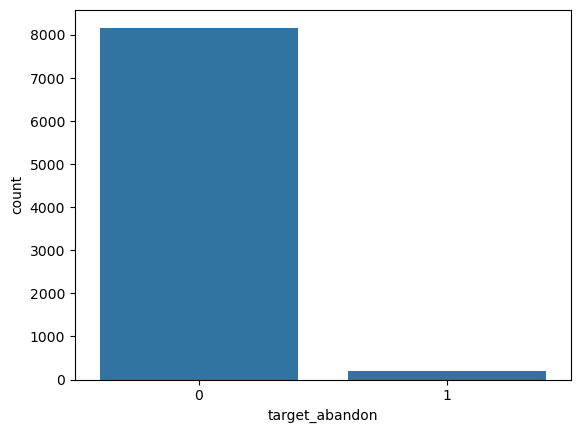

In [28]:
windows_with_ga3 = windows_with_ga2.copy()

# New abandon rate?
print(f"New abandonment rate is {windows_with_ga3['target_abandon'].mean():.4f}")

sns.countplot(data=windows_with_ga3, x='target_abandon')
plt.show()

In [29]:
windows_with_ga3.columns.isna().sum()

0

In [30]:
# Split the data
x = windows_with_ga3.drop(columns=['target_abandon'])
y = windows_with_ga3['target_abandon']

x = x.replace({pd.NA: np.nan})

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.2,
    random_state=12345,
    stratify=y  # keeps same balance of 0/1 in train and test
)



## Logistic model

In [31]:
# ===== 1) Convert time-like columns to human units (hours/days) =====
# Work on copies to avoid SettingWithCopy warnings
x_train = x_train.copy()
x_test  = x_test.copy()

# Timedelta -> HOURS
td_cols = x_train.select_dtypes(include=['timedelta64[ns]']).columns
for c in td_cols:
    x_train[c] = pd.to_timedelta(x_train[c], errors='coerce').dt.total_seconds() / 3600.0
    x_test[c]  = pd.to_timedelta(x_test[c],  errors='coerce').dt.total_seconds() / 3600.0

# Datetime -> DAYS since an anchor (min train date per column)
dt_cols = x_train.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]']).columns
for c in dt_cols:
    tr = pd.to_datetime(x_train[c], errors='coerce')
    anchor = tr.min()
    x_train[c] = (pd.to_datetime(x_train[c], errors='coerce') - anchor).dt.total_seconds() / 86400.0
    x_test[c]  = (pd.to_datetime(x_test[c],  errors='coerce') - anchor).dt.total_seconds() / 86400.0

# ===== 2) Build simple pipeline (no standardization) =====
num_cols = x_train.select_dtypes(include=[np.number]).columns
cat_cols = x_train.select_dtypes(include=['object','category','bool']).columns

pipeline = Pipeline(steps=[
    ("prep", ColumnTransformer(transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("oh", OneHotEncoder(handle_unknown="ignore", drop="first"))
        ]), cat_cols),
    ])),
    # C > 1 reduces regularization -> easier-to-see coefficients
    ("clf", LogisticRegression(max_iter=1000, solver="liblinear", C=10.0))
])

# ===== 3) Fit & evaluate =====
pipeline.fit(x_train, y_train)

y_pred  = pipeline.predict(x_test)
y_proba = pipeline.predict_proba(x_test)[:, 1]

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))



Test Accuracy: 0.9749403341288783
Test AUC: 0.49992714343999534
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1634
           1       0.00      0.00      0.00        42

    accuracy                           0.97      1676
   macro avg       0.49      0.50      0.49      1676
weighted avg       0.95      0.97      0.96      1676



c:\Users\dhung\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\dhung\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\dhung\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dhung\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contro

In [32]:
# ===== 4) Coefficients + Odds Ratios (interpretable) =====
pre = pipeline.named_steps["prep"]
clf = pipeline.named_steps["clf"]

# Feature names from ColumnTransformer (sklearn >= 1.0)
try:
    feature_names = pre.get_feature_names_out()
except AttributeError:
    # Fallback for older sklearn
    from sklearn.utils._metadata_requests import _safe_get_feature_names_out
    feature_names = _safe_get_feature_names_out(pre, input_features=x_train.columns)

coefs = clf.coef_[0]

coef_table = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs,
})
coef_table["odds_ratio"] = np.exp(coef_table["coef"])             # per +1 unit
coef_table["odds_ratio_per_10"] = np.exp(10 * coef_table["coef"]) # per +10 units (helpful for time features)
coef_table["abs_coef"] = coef_table["coef"].abs()

# Sort by influence
coef_table = coef_table.sort_values("abs_coef", ascending=False)

# Pretty display
with pd.option_context('display.float_format', '{:.8f}'.format,
                       'display.max_rows', None,
                       'display.max_colwidth', 120):
    display(coef_table.head(30))



,feature,coef,odds_ratio,odds_ratio_per_10,abs_coef
0,num__CUSTOMER_ID,-0.00000001,0.99999999,0.99999993,0.00000001
10,num__duration_min_max_event_minutes,-0.00000000,1.00000000,1.00000000,0.00000000
9,num__last_event_time,-0.00000000,1.00000000,1.00000000,0.00000000
8,num__first_event_time,-0.00000000,1.00000000,1.00000000,0.00000000
2,num__WINDOW_END_LOCAL,-0.00000000,1.00000000,1.00000000,0.00000000
3,num__WINDOW_END_LOCAL_event_cutoff,-0.00000000,1.00000000,1.00000000,0.00000000
1,num__WINDOW_START_LOCAL,-0.00000000,1.00000000,1.00000000,0.00000000
7,num__ORDER_CREATED_DATE_LOCAL,-0.00000000,1.00000000,1.00000000,0.00000000
11,num__mode_event_day,-0.00000000,1.00000000,1.00000000,0.00000000
4,num__WINDOW_FREQUENCY,-0.00000000,1.00000000,1.00000000,0.00000000
